In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import yfinance as yf

In [3]:
import datetime
import time
import requests
import io

In [4]:
data = yf.download("^GSPC", start="2000-01-01", end="2023-10-29")

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [6]:
data.shape

(5994, 6)

# Train Test Split

In [7]:
# Train Test split
train_size = int(0.8*data.shape[0])
print(train_size)

4795


In [8]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size:]

# Extracting Features

In [9]:
def augment_features(dataframe):
  fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
  frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
  fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
  new_dataframe = pd.DataFrame({'delOpenClose':fracocp,
                                'delHighOpen':frachp,
                                'delLowOpen':fraclp,})
  new_dataframe.set_index(dataframe.index)

  return new_dataframe

In [10]:
def extract_features(dataframe):
  return np.column_stack((dataframe['delOpenClose'],dataframe['delHighOpen'],dataframe['delLowOpen']))




In [11]:
features = extract_features(augment_features(train_data))

In [12]:
features.shape

(4795, 3)

# Model

In [13]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.2 MB/s eta 0:00:00


In [14]:
from hmmlearn.hmm import GaussianHMM

In [15]:
model = GaussianHMM(n_components=10)
#n_components?

In [16]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

In [17]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

In [18]:
sample_space_fracocp = np.linspace(fracocp.min(),fracocp.max(),50)
sample_space_fraclp = np.linspace(fraclp.min(),fraclp.max(),10)
sample_space_frachp = np.linspace(frachp.min(),frachp.max(),10)

In [19]:
possible_outcomes = np.array(list(itertools.product(sample_space_fracocp,
                                                    sample_space_frachp,
                                                    sample_space_fraclp)))
print(possible_outcomes)

[[-0.05709928  0.          0.        ]
 [-0.05709928  0.          0.00711312]
 [-0.05709928  0.          0.01422623]
 ...
 [ 0.05487571  0.05499636  0.04979182]
 [ 0.05487571  0.05499636  0.05690493]
 [ 0.05487571  0.05499636  0.06401805]]


- 경우의 수

In [20]:
num_latent_days = 50
num_days_to_predict = 300

In [21]:
from tqdm import tqdm
predicted_close_price = []
for i in tqdm(range(num_days_to_predict)):
  previous_data_start_index = max(0, i - num_latent_days)
  previous_data_end_index = max(0,i)

  previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

  # 여기에서는 경우의 수를 보고자 한다.
  outcome_scores = []
  for outcome in possible_outcomes:
    total_data = np.row_stack((previous_data, outcome))
    outcome_scores.append(model.score(total_data))

  most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)] # index를 얻음. 높은 확률 얻기 위함.
  predicted_close_price.append(test_data.iloc[i]['Open']*(1+most_probable_outcome[0]))
  # 0번째 Column이 (Close-Open)/Open 값이기 때문임.

100%|██████████| 300/300 [10:24<00:00,  2.08s/it]


- 정리하자면 predicted_close_price는 predicted value which get from past data every daily data.

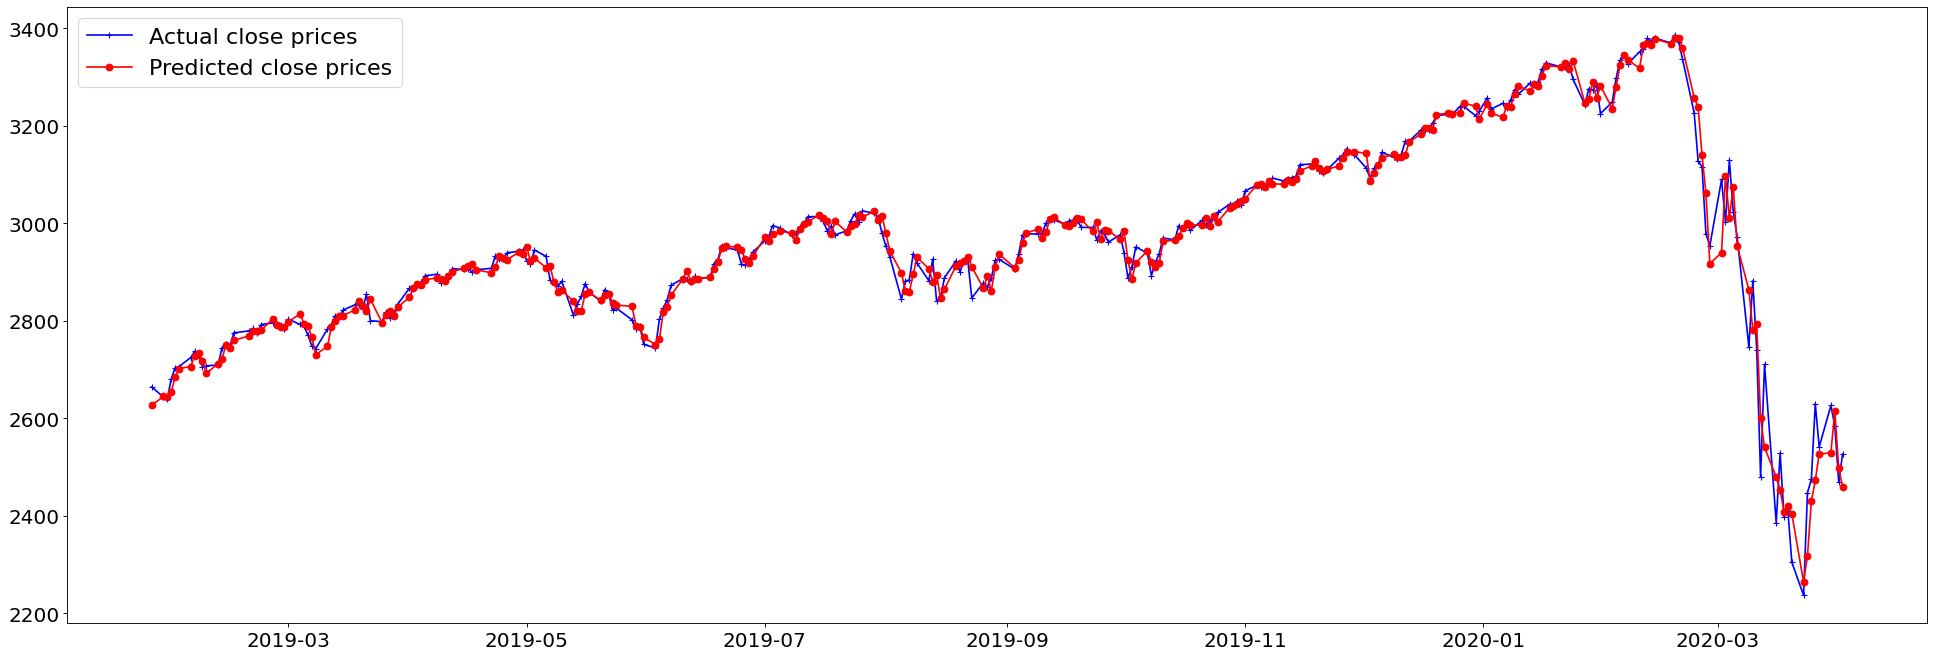

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_price, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

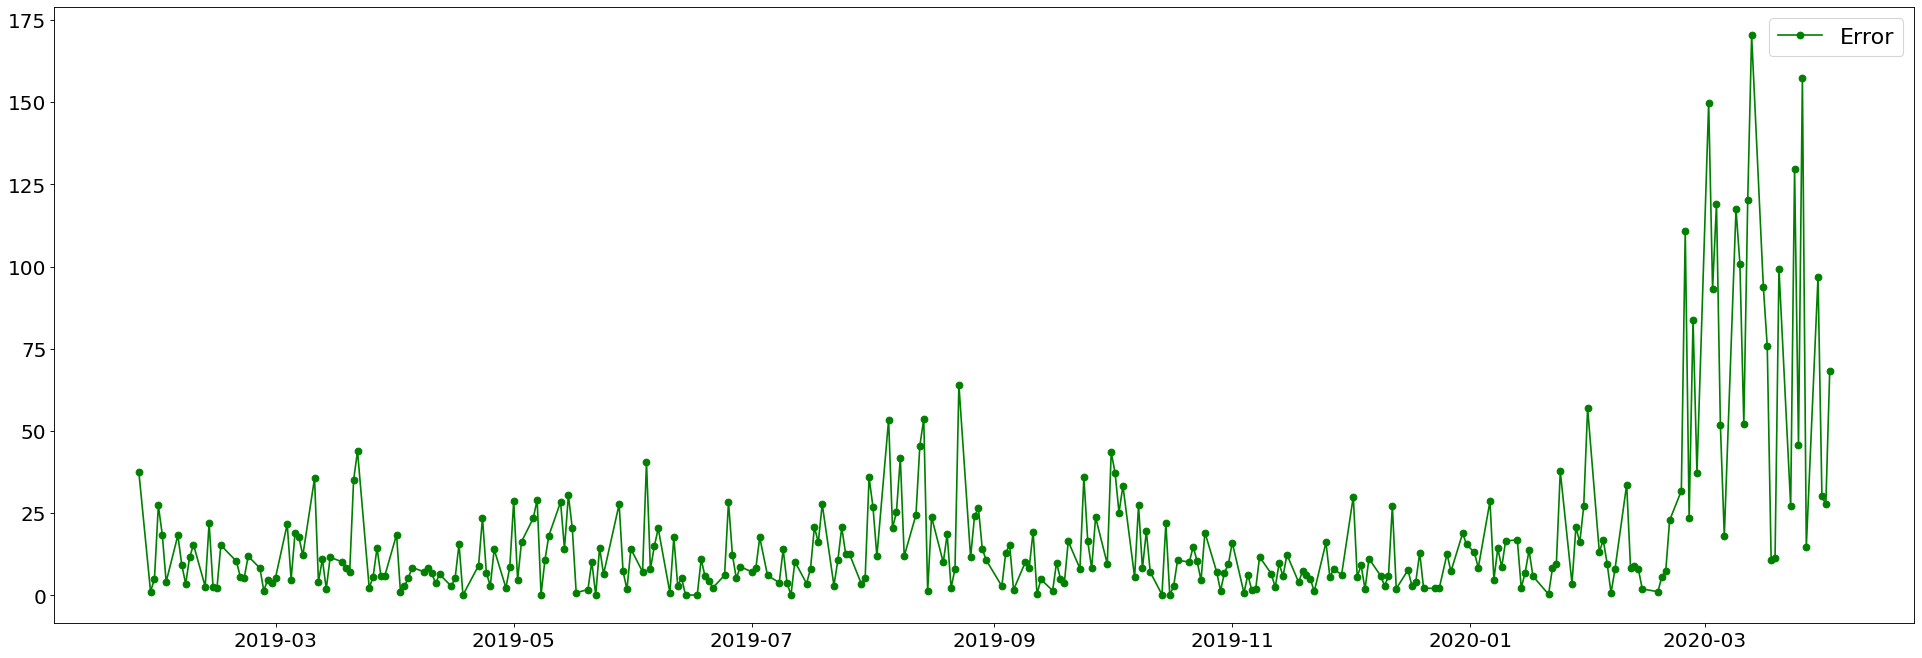

In [24]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_price)

plt.figure(figsize=(30,10) ,dpi=80)
plt.plot(x_axis, ae, 'go-', label='Error')
plt.legend(prop={'size':20})
plt.show()

In [25]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 170.31558216440408
Min error observed = 0.070945272400877
Mean error observed = 18.305352920406854


In [26]:
num_latent_days_values = [10, 20, 30, 40, 50, 60]
baseline_num_latent_days = 50
n_components_values = [4, 6, 8, 10, 12, 14]
baseline_n_componets = 10
num_steps_values = [10, 20, 40, 50]
baseline_num_steps = 50

# length
num_days_to_predict = 100 # We don't need to predict as many days as before

# Grid Search

## Num Component(Model Component)

In [27]:
mae_num_components = []
for num_component in n_components_values:
  model = GaussianHMM(n_components=num_component)
  model.fit(features_train)
  predicted_close_price = []

  for i in tqdm(range(num_days_to_predict)):
    previous_data_start_index = max(0, i - baseline_num_latent_days)
    previous_data_end_index = max(0, i)

    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores=[]
    for outcome in possible_outcomes:
      total_data = np.row_stack((previous_data,outcome))
      outcome_scores.append(model.score(total_data))

    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_price.append(test_data.iloc[i]['Open']*(1+most_probable_outcome[0]))

  mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_price)).mean())





100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


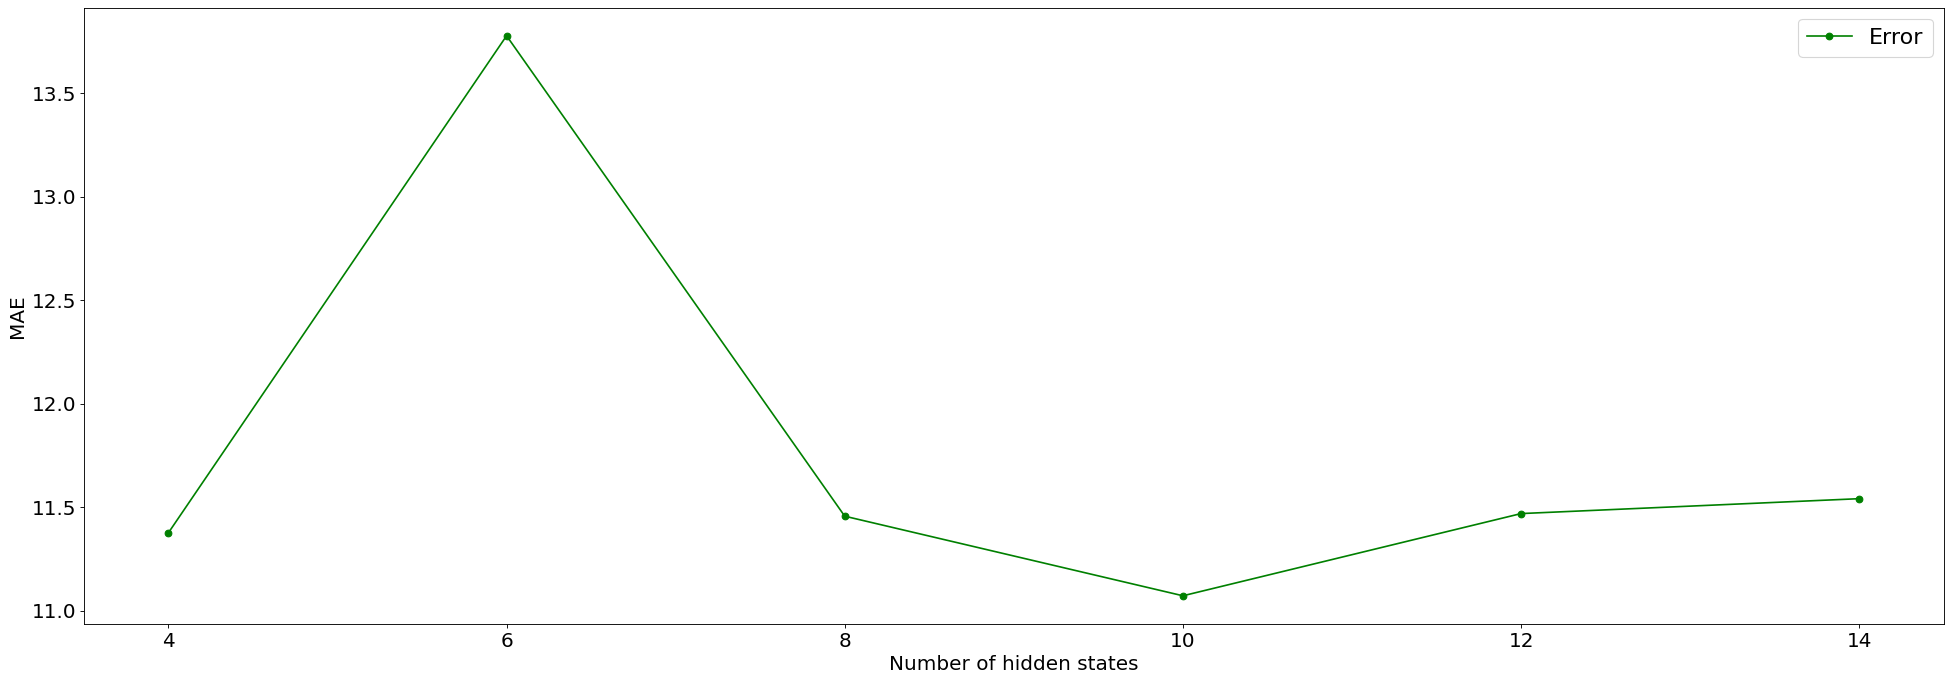

In [28]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

## NumStep(경우의 수)

In [31]:
mae_num_steps = []
model = GaussianHMM(n_components=baseline_n_componets)
# 10개가 가장 Loss(MAE)가 낮긴하다.
model.fit(features_train)

for num_step in num_steps_values:
  sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), num_step)
  sample_space_fraclp = np.linspace(fraclp.min(), fraclp.max(), int(num_step/5))
  sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(num_step/5))

  possible_outcomes=np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
  # 경우의 수

  predicted_close_price = []

  for i in tqdm(range(num_days_to_predict)):
    previous_data_start_index = max(0, i-baseline_num_latent_days)
    previous_data_end_index = max(0, i)

    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes:
      total_data = np.row_stack((previous_data, outcome))
      outcome_scores.append(model.score(total_data))

    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_price.append(test_data.iloc[i]['Open']*(1+most_probable_outcome[0]))

  mae_num_steps.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_price)).mean())



100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


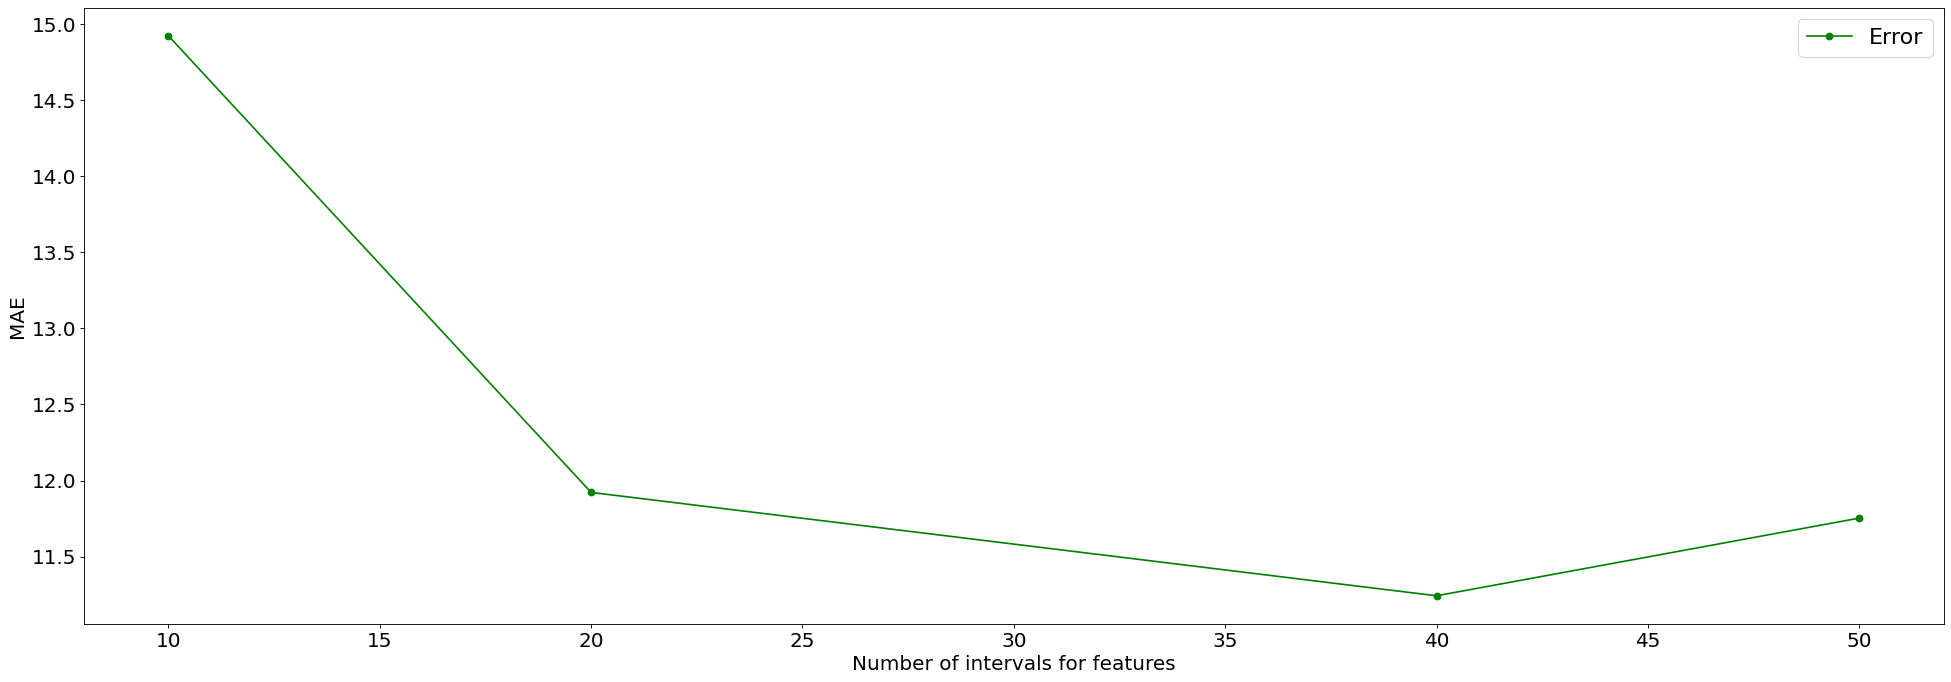

In [32]:
plt.figure(figsize=(30,10), dpi=80)

plt.plot(num_steps_values, mae_num_steps, 'go-', label="Error")
plt.xlabel("Number of intervals for features")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()